## This script uses VAR modeling on the multivariate time series per country (initial modeling)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [12]:
df_orig = pd.read_csv('.\Market_food_prices_w_temp_reduced.csv')
country_dict = dict(zip(df_orig.country_id,df_orig.country))
text_file1 = open(".\plot-var-model\init\VAR_modeling_summary.doc", "w")
plt.rcParams["figure.figsize"] = [16, 12]

Calculate MAPE

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Fitting the model using VAR

In [14]:
def var_model(df_country,value,log):
    df_trans = df_country.copy()

    #get dynamic size of split based on time series
    init = int(len(df_trans) * 0.75) #get the 75% first
    if (init%12==0):          #check if it has the full year
        size = init
    else:
        size = int(init/12)*12 + 12 #calculate the next full year split

    train, valid = df_trans[0:size], df_trans[size:len(df_trans)]

    model = VAR(endog=train)
    model_fit = model.fit()
    print(model_fit.summary(), file=text_file1)

    print('fitting the model...')
    cols = train.columns
    prediction = model_fit.forecast(model_fit.y, steps=len(valid))

    #converting predictions to dataframe
    pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols])
    for j in range(0, 2):
        for i in range(0, len(prediction)):
            pred.iloc[i][j] = prediction[i][j]

    #check rmse
    for i in cols:
        print('RMSE value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])), file=text_file1)
        print('MAE value for', i, 'is : ', mean_absolute_error(pred[i], valid[i]), file=text_file1)
        print('MAPE value for', i, 'is : ', mean_absolute_percentage_error(pred[i], valid[i]), file=text_file1)

    valid = valid.reset_index()
    pred = pred.reset_index()
    valid.columns = ['period', 'avg_temp-test', 'price_in_USD-test']

    pred['period'] = valid['period']
    pred.columns = ['sno', 'avg_temp-pred', 'price_in_USD-pred','period']
    valid = valid.set_index('period')
    pred = pred.set_index('period')
    pred = pred.drop('sno', 1)

    plt.figure()
    plt.plot(train['price_in_USD'], label='test set', color='blue')
    plt.plot(valid['price_in_USD-test'], label='test set', color='seagreen')
    plt.plot(pred['price_in_USD-pred'], label='prediction', color='red')
    plt.title('VAR modeling - initial -  ' + value)
    plt.xlabel('period')
    plt.legend()
    fig = plt.gcf()
    fig.savefig('./plot-var-model/init/pred/'+ value + '.png')

Bangladesh


C:\Users\Janelle\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


FileNotFoundError: [Errno 2] No such file or directory: './plot-var-model/init/acorr/Bangladesh-var.png'

<Figure size 1152x864 with 0 Axes>

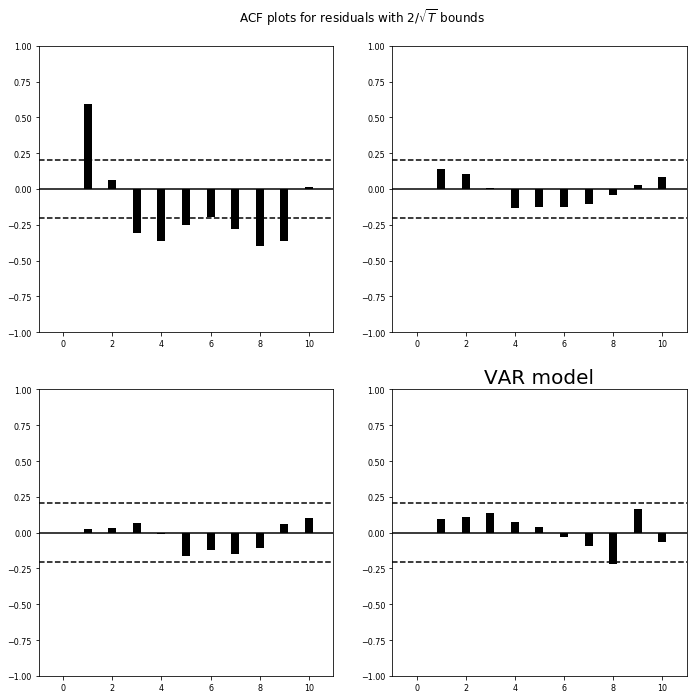

In [15]:
for key, value in country_dict.items():
    df_country = pd.read_csv('.\countries\country_df_'+ value +'.csv')
    df_country['period'] = pd.to_datetime(df_country.period, format='%Y-%m-%d')
    drop_cols = ['country_id', 'country', 'commodity_purchased', 'commodity_purchase_id']
    df_country.drop(drop_cols, axis=1, inplace=True)
    df_country_merge = pd.DataFrame()
    df_country_merge = df_country.groupby(['period','avg_temp'])['price_in_USD'].mean().reset_index()
    df_country_merge.sort_values(by='period', inplace=True)
    df_country_merge = df_country_merge.set_index('period')
    print('='*70, file=text_file1)
    print(str(value), file=text_file1)
    print('=' * 70, file=text_file1)
    print(str(value))
    var_model(df_country_merge, value, 'N')
